# Solar Array Cost Prediction

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

import scipy.stats as stats
import statsmodels.api as sm

import os
from pprint import pprint

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# format float in pandas
# pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

plt.style.use('seaborn-white')
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.xmargin'] = 0.02
rcParams['axes.ymargin'] = 0.02
            
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.alpha'] = 0.2
rcParams['grid.color'] = 'black'
          
rcParams['figure.titlesize'] = 'x-large'
rcParams['figure.edgecolor']= 'black'
rcParams['figure.facecolor'] = 'white'
rcParams['figure.figsize'] = [12, 8]

rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

In [3]:
pv_df = pd.read_csv('pv_df_clean_2.csv', low_memory=False)
# pv_df.info()

In [4]:
# Convert to datetime
# =============================================================================
# set index to the date installed and sort index
date_time = '%Y-%m-%d'
datetime = pd.to_datetime(pv_df['date_installed'], format=date_time)
clean_pv = pv_df.set_index(datetime).sort_index()

In [5]:
clean_pv = clean_pv['1998':'2017']

## Feature Engineering
### Combine Technology Type

Combine features which appear infrequently into a single group called '*other*'. This will reduce the size of the sparse matrix that will be created when categorical variables are encoded. Additionally, new features can be created from existing numeric and categoric features. 


In [6]:
def counts_of(feature, df=clean_pv, freq=True):
    """
    Count occurence or frequency.
    """
    if freq:
        return df[feature].value_counts() / np.count_nonzero(df[feature].notnull()) * 100
    return df[feature].value_counts()

def combine_features(feature, threshold, df=clean_pv, new_tag='others'):
    """
    Combine features based on their frequency.
    Variables appearing less frequently will be combined together.
    
    """
    counts = counts_of(feature)
    mask = df[feature].isin(counts[counts < threshold].index)
    df[feature][mask] = new_tag
    
def percent_missing(df, threshold=50, drop=False):
    """
    Calculate percent missing values in each column.
    
    Returns a series showing the proportion of missing vals in each column
    
    Drop columns which contain more than <threshold> missing values.
    """
    ms = (np.sum(df.isnull()) / len(df)) * 100
    if drop:
        return df.drop(labels=ms[ms >= threshold].index, axis=1)     
    else:
        return ms.sort_values()

In [7]:
# TECH_1
counts_of('tech_1').mean()

9.090909090909092

In [8]:
combine_features('tech_1',
                 threshold=counts_of('tech_1').mean(),
                 new_tag='other'
                )

# counts_of('tech_1', freq=False)

In [9]:
counts_of('tech_1')

poly     58.633855
mono     38.337607
other     3.028538
Name: tech_1, dtype: float64

In [10]:
# TRACKING TYPE
# frequency
counts_of('tracking_type')

fixed          99.670780
single-axis     0.141963
dual-axis       0.110348
mixed           0.076909
Name: tracking_type, dtype: float64

In [11]:
combine_features('tracking_type',
                 threshold=counts_of('tracking_type').mean(),
                 new_tag='has_axis'
                )

counts_of('tracking_type')

fixed       99.67078
has_axis     0.32922
Name: tracking_type, dtype: float64

In [12]:
percent_missing(clean_pv)

date_installed                  0.000000
year                            0.000000
day                             0.000000
month                           0.000000
size_catg                       0.000000
total_cost                      0.000000
3rdparty                        0.000000
cost_mo_agg_med                 0.000000
annual_pv_prod                  0.000000
month_install_cnt               0.000000
state                           0.000000
cost                            0.000000
size_kw                         0.000000
zipcode                         0.000000
install_type                    0.000000
cost_per_watt                   0.000654
annual_insolation               0.000817
power_density                   0.000817
area_est                        0.000817
county                          0.643225
incentive_count                 0.756610
city                           24.653145
incentive_prog_names           24.891679
utility_clean                  25.227424
installer       

In [13]:
pv_dm = clean_pv.copy()

In [14]:
# NOTE:
# - December is cheaper apparently, but the difference between MIN and MAX doesn't seem significant enough
#   for making predictions

(pv_dm['cost_mo_agg_med'] / pv_dm['month_install_cnt']).describe()
clean_pv.groupby('month')['cost'].mean().sort_values()

month
12    29404.758917
11    29414.329758
10    29449.837032
9     29485.749490
7     29766.724061
8     29841.020024
6     30371.166334
5     30474.619863
2     30800.167366
1     30954.987227
4     30958.332673
3     31155.114718
Name: cost, dtype: float64

In [15]:
# NOTE:
# - not a good predictor of cost as the difference seems to be insignificant
pv_dm.groupby('tracking_type')['cost'].median()
# pv_dm['tracking_type'].value_counts()

tracking_type
fixed       27700.00
has_axis    26705.22
Name: cost, dtype: float64

In [16]:
pv_dm.groupby('tech_1')['cost'].median()

tech_1
mono     28056.0
other    30500.0
poly     26624.0
Name: cost, dtype: float64

In [17]:
def to_frequency(column_name, df):
 
    new_name = str(column_name) + '_freq'   
    temp = df[column_name].value_counts() / len(df)
    df[new_name] = df[column_name].map(temp).astype('float')
    return df

# select numeric dtype 
def get_numeric_data(df):
    return df.select_dtypes(include=[np.float64, np.int64])

# select categoric dtype 
def get_non_numeric_data(df):
    return df.select_dtypes(exclude=[np.float64, np.int64])

In [18]:
def process_data(df, 
                 to_drop=['date_installed', 'total_cost', '3rdparty', 'incentive_prog_names',
                          'install_type', 'city', 'county', 'size_catg', 'model1_clean', 'installer', 
                          'utility_clean', 'day', 'month', 'cost_mo_agg_med', 'zipcode', 'incentive_count'],
                ):
    try:
        df = clean_pv.copy()
        
        # drop columns which contain more than 50% missing values
        df = percent_missing(df, 50, drop=True)
        
        # drop features
        df = df.drop(to_drop, axis=1)

        # adjust dtype
        df['year'] = df['year'].astype('category')
#         df['zipcode'] = df['zipcode'].astype(str)
        
        # ENCODE CATEGORICAL FEATURES
        # FREQUENCIES: categorical to continous encoding
        to_freq_cols = get_non_numeric_data(df)
        for item in to_freq_cols:
            df = to_frequency(item, df)
        
    except:
        print(sys.exc_info()[0])
        print(sys.exc_info()[1])
    
    return df

In [19]:
# pv_dm.info()
process_data(pv_dm).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612072 entries, 1998-04-08 to 2017-12-28
Data columns (total 17 columns):
state                 612072 non-null object
size_kw               612072 non-null float64
cost_per_watt         612068 non-null float64
cost                  612072 non-null float64
tech_1                358820 non-null object
annual_pv_prod        612072 non-null float64
annual_insolation     612067 non-null float64
tilt1                 307962 non-null float64
tracking_type         328959 non-null object
area_est              612067 non-null float64
power_density         612067 non-null float64
year                  612072 non-null category
month_install_cnt     612072 non-null int64
state_freq            612072 non-null float64
tech_1_freq           358820 non-null float64
tracking_type_freq    328959 non-null float64
year_freq             612072 non-null float64
dtypes: category(1), float64(12), int64(1), object(3)
memory usage: 100.0+ MB


### Train-Test Split
Data will be split into training and testing subsets such that training will occur on past data and predictions will be made on more recent data. The ratio will be approximately 80% train and 20% test.

In [20]:
def train_test_df(df, end_date, start_date, show_split=False):
    """
    Split dataframe into Training and Testing set by dates.
    
    Training set will be past data, from start to `split_date`.
    
    Testing set will more future data, from `split_date` to end.
    
    The goal is to have about 80/20 split.
    """
    train_set = df.loc[:end_date, :]
    test_set = df.loc[start_date:, :]
    if show_split:
        # return split proportion of TRAIN, TEST
        return len(train_set)/len(df), len(test_set)/len(df)
    return train_set, test_set

def train_test_split(df, end_date, start_date, target='cost'):
    """
    Returns arrays of X, y train and test sets
    Exclude additional features with param `drop_features` from predictors arrays
    
    Parameters:
    -----------
        df_train:      training set
        df_test:       testing set
        target:        target variable
        drop_features: drop additional features from df
    
    Returns:
    -----------
        X_train, X_test, y_train, y_test
    """
    df_train, df_test = train_test_df(df, end_date, start_date)
    
    X_train = df_train.drop(target, axis=1)
    X_test = df_test.drop(target, axis=1)
    y_train = df_train[[target]]
    y_test = df_test[[target]]
    return X_train, y_train, X_test, y_test
    
def drop_features(df, drop_this):
    return df.drop(drop_this, axis=1)


In [21]:
pv_dm = process_data(pv_dm)

In [22]:
train_test_df(pv_dm, '2015-05-31', '2015-06-01', show_split=True)

(0.7849256296644839, 0.21507437033551607)

# Correlations

In [23]:
pv_dm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612072 entries, 1998-04-08 to 2017-12-28
Data columns (total 17 columns):
state                 612072 non-null object
size_kw               612072 non-null float64
cost_per_watt         612068 non-null float64
cost                  612072 non-null float64
tech_1                358820 non-null object
annual_pv_prod        612072 non-null float64
annual_insolation     612067 non-null float64
tilt1                 307962 non-null float64
tracking_type         328959 non-null object
area_est              612067 non-null float64
power_density         612067 non-null float64
year                  612072 non-null category
month_install_cnt     612072 non-null int64
state_freq            612072 non-null float64
tech_1_freq           358820 non-null float64
tracking_type_freq    328959 non-null float64
year_freq             612072 non-null float64
dtypes: category(1), float64(12), int64(1), object(3)
memory usage: 100.0+ MB


## Heatmap 1

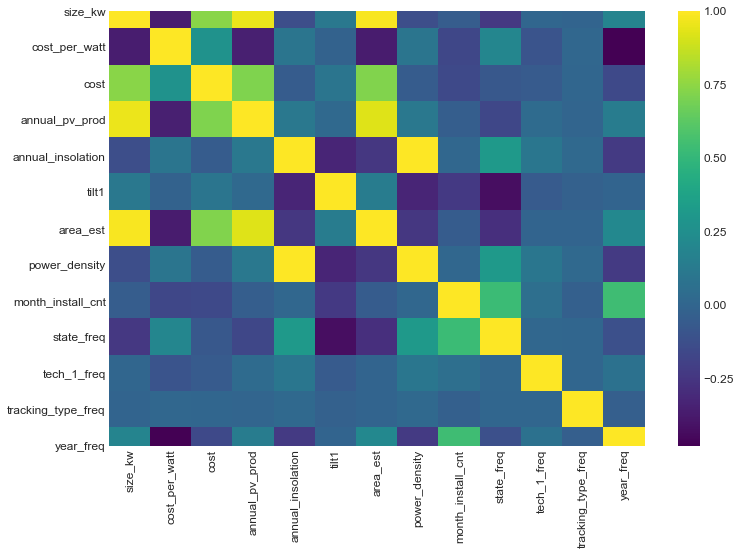

cost                  1.000000
size_kw               0.739517
area_est              0.718252
annual_pv_prod        0.712267
cost_per_watt         0.271661
tilt1                 0.096764
tracking_type_freq    0.002464
annual_insolation    -0.052751
power_density        -0.052751
tech_1_freq          -0.059597
state_freq           -0.076588
month_install_cnt    -0.152681
year_freq            -0.155107
Name: cost, dtype: float64


In [24]:
# HEATMAP
# [['size_kw', 'cost_per_watt', 'cost', 'annual_pv_prod', 'annual_insolation', 'tilt1',
#                                       'incentive_count', 'area_est', 'power_density']]

# drop_this = ['cost_mo_agg_med', ]

numeric_df = get_numeric_data(pv_dm)

sns.heatmap(numeric_df.corr(), cmap='viridis')
plt.show()

corr_ = numeric_df.corr()['cost'].sort_values(ascending=False)
print(corr_)

high_corr = corr_[abs(corr_) > 0.10]

## Heatmap 2
Feature **size_kw** multiplied by every feature

In [25]:
sample_df = pv_dm.copy()
size_constant = (sample_df['size_kw'])

#  
# features = ['size_kw', 'annual_pv_prod', 'cost_per_watt', 'area_est', 'power_density', 'annual_insolation', 'month_install_cnt']

# remove 'cost' so there are no operations performed on it
sample_df = get_numeric_data(sample_df).drop('cost', axis=1)

features = sample_df.columns.to_list()

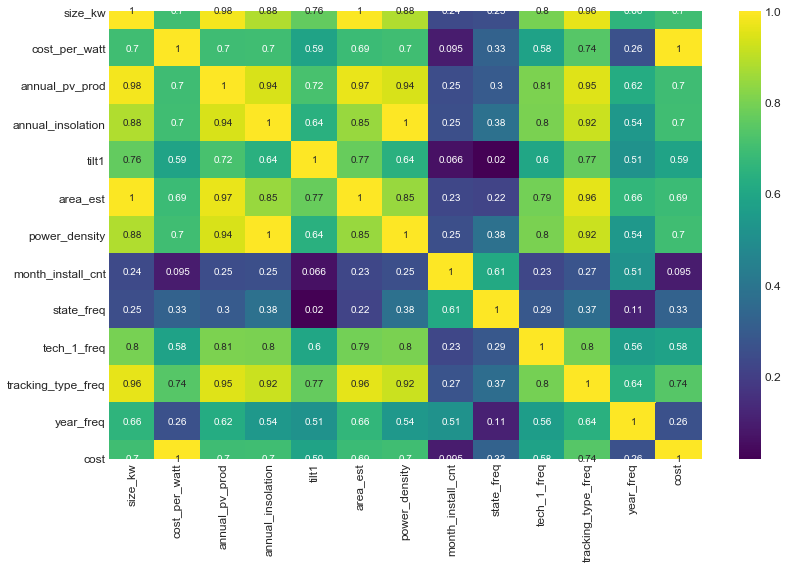

month_install_cnt     0.095101
year_freq             0.264695
state_freq            0.325470
tech_1_freq           0.583460
tilt1                 0.588652
area_est              0.688254
annual_pv_prod        0.696183
size_kw               0.700050
annual_insolation     0.700725
power_density         0.700725
tracking_type_freq    0.742255
cost_per_watt         0.999999
cost                  1.000000
Name: cost, dtype: float64

In [26]:
# instantiate new dataframe
df_2 = pd.DataFrame()

for col in features:
    df_2 = pd.concat([df_2, sample_df[col] * size_constant], axis=1)
    
col_labels = [str(item) for item in features]
df_2.columns = col_labels

# put back column 'cost'
df_2 = pd.concat([df_2, pv_dm['cost']], axis=1)

# plot heatmap
sns.heatmap(df_2.corr(), cmap='viridis', annot=True)
plt.tight_layout()
plt.show()

df_2.corr()['cost'].sort_values()

In [27]:
df_2.describe()

,size_kw,cost_per_watt,annual_pv_prod,annual_insolation,tilt1,area_est,power_density,month_install_cnt,state_freq,tech_1_freq,tracking_type_freq,year_freq,cost
count,612072.000000,612068.000000,612072.000000,612067.000000,307962.000000,612067.000000,612067.000000,612072.000000,612072.000000,358820.000000,328959.000000,612072.000000,612072.000000
mean,35.833464,30050.221504,52418.257345,10734.958294,128.665610,202.130725,1449.219370,17665.537435,1.899048,1.608612,3.006234,0.850356,30050.351214
std,29.667400,13022.352179,42488.750975,4727.445746,75.737579,170.423948,638.205176,23533.676856,1.585883,0.807186,1.250431,0.694213,13022.343215
min,0.002500,227.000000,3.821965,106.980968,0.018000,0.011948,14.442431,0.064000,0.000003,0.009055,0.002123,0.000017,227.000000
25%,13.542400,20360.000000,19834.154418,7106.023770,75.924000,75.698096,959.313209,3634.260000,0.516030,1.031202,2.089160,0.358897,20360.000000
50%,27.040000,28380.000000,40394.369641,10109.815236,112.710000,153.047321,1364.825057,9810.720000,1.618085,1.519308,2.849829,0.653704,28380.000000
75%,49.280400,38306.100000,72785.507784,13763.732082,163.200000,279.119275,1858.103831,21145.800000,3.030978,2.096778,3.811542,1.124985,38307.500000
max,196.000000,68040.000000,249172.563919,28412.569308,1764.000000,1180.920687,3835.696857,233818.750000,8.207678,4.812277,7.499549,3.923084,67770.000000


## Heatmap 3
Feature **size_kw** multiplied by every feature *and* compute **log**. Target variable **cost** is left untouched.

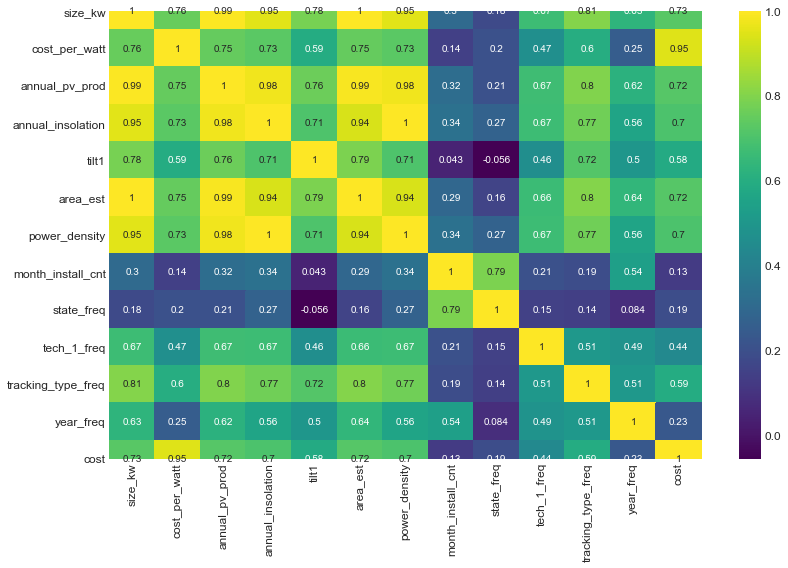

month_install_cnt     0.127606
state_freq            0.190222
year_freq             0.232272
tech_1_freq           0.441077
tilt1                 0.584158
tracking_type_freq    0.593481
annual_insolation     0.702716
power_density         0.702716
area_est              0.720701
annual_pv_prod        0.722412
size_kw               0.727110
cost_per_watt         0.950220
cost                  1.000000
Name: cost, dtype: float64

In [28]:
df_log = pd.DataFrame()
# sample_df = get_numeric_data(sample_df).drop('cost', axis=1)

for col in features:
    df_log = pd.concat([df_log, np.log(sample_df[col] * (sample_df['size_kw'].values))], axis=1)
    
col_labels = [str(item) for item in features]
df_log.columns = col_labels

# put back column 'cost'
df_log = pd.concat([df_log, pv_dm['cost']], axis=1)

# plot heatmap
sns.heatmap(df_log.corr(), cmap='viridis', annot=True)
plt.tight_layout()
plt.show()

df_log.corr()['cost'].sort_values()


## Multiple Linear Regression
The goal is to create a pipeline and try various regressor with the pipeline. Asses the model with various metrics then take the neccessary steps to improve the model.

In [29]:
def metrics(y_true, y_pred):
    return (
        r2_score(y_true, y_pred), 
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred))
    )

def model_metrics(y_train, y_test, y_pred, y_train_pred):
    print('Metrics'.center(50, '-'))
    print('Train set:')
    print('R^2: ', metrics(y_train, y_train_pred)[0])
    print('MAE: ', metrics(y_train, y_train_pred)[1])
    print('RMSE:', metrics(y_train, y_train_pred)[2])  
    print('='*50)
    print('Test set:')
    print('R^2: ', metrics(y_test, y_pred)[0])
    print('MAE: ', metrics(y_test, y_pred)[1])
    print('RMSE:', metrics(y_test, y_pred)[2])
    print('='*50)

In [30]:
# high_corr.drop('cost').index.to_list()
# get_numeric_data(X_train).columns.to_list()
# pv_dm.info()

In [31]:
df_log.index = pd.to_datetime(df_log.index)
df_2.index = pd.to_datetime(df_2.index)

In [32]:
df_log.describe()

,size_kw,cost_per_watt,annual_pv_prod,annual_insolation,tilt1,area_est,power_density,month_install_cnt,state_freq,tech_1_freq,tracking_type_freq,year_freq,cost
count,612072.000000,612068.000000,612072.000000,612067.000000,307962.000000,612067.000000,612067.000000,612072.000000,612072.000000,358820.000000,328959.000000,612072.000000,612072.000000
mean,3.199429,10.205577,10.495183,9.174538,4.687569,4.922852,7.172057,8.903014,0.017297,0.300203,0.993321,-0.567426,30050.351214
std,0.961279,0.484433,0.952915,0.484646,0.614848,0.967538,0.484646,1.634013,1.454683,0.700886,0.552149,1.073168,13022.343215
min,-5.991465,5.424950,1.340765,4.672651,-4.017384,-4.427166,2.670170,-2.748872,-12.582668,-4.704464,-6.154793,-10.996840,227.000000
25%,2.605826,9.921327,9.895161,8.868698,4.329733,4.326753,6.866218,8.198161,-0.661590,0.030725,0.736762,-1.024721,20360.000000
50%,3.297317,10.253440,10.606446,9.221262,4.724818,5.030747,7.218782,9.191231,0.481243,0.418255,1.047259,-0.425100,28380.000000
75%,3.897526,10.553364,11.195272,9.529792,5.094976,5.631639,7.527312,9.959197,1.108885,0.740402,1.338034,0.117770,38307.500000
max,5.278115,11.127851,12.425901,10.254587,7.475339,7.074050,8.252106,12.362302,2.105070,1.571170,2.014843,1.366878,67770.000000


In [33]:
(df_2).describe()

,size_kw,cost_per_watt,annual_pv_prod,annual_insolation,tilt1,area_est,power_density,month_install_cnt,state_freq,tech_1_freq,tracking_type_freq,year_freq,cost
count,612072.000000,612068.000000,612072.000000,612067.000000,307962.000000,612067.000000,612067.000000,612072.000000,612072.000000,358820.000000,328959.000000,612072.000000,612072.000000
mean,35.833464,30050.221504,52418.257345,10734.958294,128.665610,202.130725,1449.219370,17665.537435,1.899048,1.608612,3.006234,0.850356,30050.351214
std,29.667400,13022.352179,42488.750975,4727.445746,75.737579,170.423948,638.205176,23533.676856,1.585883,0.807186,1.250431,0.694213,13022.343215
min,0.002500,227.000000,3.821965,106.980968,0.018000,0.011948,14.442431,0.064000,0.000003,0.009055,0.002123,0.000017,227.000000
25%,13.542400,20360.000000,19834.154418,7106.023770,75.924000,75.698096,959.313209,3634.260000,0.516030,1.031202,2.089160,0.358897,20360.000000
50%,27.040000,28380.000000,40394.369641,10109.815236,112.710000,153.047321,1364.825057,9810.720000,1.618085,1.519308,2.849829,0.653704,28380.000000
75%,49.280400,38306.100000,72785.507784,13763.732082,163.200000,279.119275,1858.103831,21145.800000,3.030978,2.096778,3.811542,1.124985,38307.500000
max,196.000000,68040.000000,249172.563919,28412.569308,1764.000000,1180.920687,3835.696857,233818.750000,8.207678,4.812277,7.499549,3.923084,67770.000000


In [34]:
# np.logspace(-2, 2, 10)

In [35]:
# # categorical_df = pd.concat([pv_dm[['state']], df_2.drop('month_install_cnt', axis=1)], axis=1)

# X_train, y_train, X_test, y_test = train_test_split(df_2.drop('month_install_cnt', axis=1), 
#                                                     '2015-05-31', '2015-06-01')

# # X_train, y_train, X_test, y_test = train_test_split(pv_dm.drop(['tech_1', 'tracking_type', 'state', 'year', 'tilt1'], axis=1), 
# #                                                     '2015-05-31', '2015-06-01')

# params = {'alphas': np.logspace(-2, 2, 10),
# #           'random_state': 11,
#           'cv': 5,
#           'scoring': make_scorer(mean_squared_error, greater_is_better=False)
#          }
# regressor = linear_model.RidgeCV(**params
#                               )
# numeric_features = get_numeric_data(X_train).columns.to_list()
# categorical_features = get_non_numeric_data(X_train).columns.to_list()

# # Pipeline 1: preprocess numeric data
# numeric_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
# #     ('transformer', QuantileTransformer(output_distribution='normal')),
#     ('scaler', RobustScaler()),
# #     ('poly', PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)),
# ])

# # Pipeline 2: preprocess categorical features, if any
# categorical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', dtype=np.int32)),
# ])

# # COLUMN TRASNFORMER
# col_tx = make_column_transformer(
#     (numeric_transformer, numeric_features),
#     (categorical_transformer, categorical_features),
#     n_jobs=-1
# )

# # MODEL PIPELINE
# steps = [
#     ('preprocessor', col_tx),
# #     ('feature select', SelectKBest(f_regression, k=6)),
#     ('regressor', regressor)
# ]

# model = Pipeline(steps)

# fit_start = time.time()
# model.fit(X_train, y_train)
# print('Fit time:', time.time() - fit_start)
# y_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)

# model_metrics(y_train, y_test, y_pred, y_train_pred)
# print('Alpha:', model.named_steps['regressor'].alpha_)

# Building the Pipeline

In [36]:

def build_pipeline(regressor, poly_degree=0, imputer_strat='mean', k_select=6, **kwargs):
    
#     X_train, y_train, X_test, y_test = train_test_split(data.drop('month_install_cnt', axis=1), 
#                                                     '2015-05-31', '2015-06-01')
    
    numeric_features = get_numeric_data(X_train).columns.to_list()
    categorical_features = get_non_numeric_data(X_train).columns.to_list()
    
#     print('Numeric features:', len(numeric_features))
#     print('Categrical features:', len(categorical_features))

    # Pipeline 1: preprocess numeric data
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
#         ('func transformer', FunctionTransformer(func=np.sqrt,
#                                                  inverse_func=np.square
#                                                 )),      
        ('scaler', RobustScaler()),        
    ])
    # Pipeline 2: preprocess categorical features, if any
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', dtype=np.int32)),
    ])
    # COLUMN TRASNFORMER
    col_tx = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        n_jobs=-1
    )
    # MODEL PIPELINE
    steps = [
        ('preprocessor', col_tx),
        ('feature select', SelectKBest(f_regression, k=k_select)),
#         ('target regressor', TransformedTargetRegressor(regressor=regressor(**kwargs),
#                                                         func=np.sqrt,
#                                                         inverse_func=np.square)),
        ('regressor', regressor(**kwargs)),       
    ]
    # add step for polynomial features
    if poly_degree > 0:
        print('Degree:', poly_degree)
        steps.insert(2, 
                     ('poly features', PolynomialFeatures(degree=poly_degree,
                                                          interaction_only=True,
                                                          include_bias=True))
                    )
    return Pipeline(steps)


def coefficients(model):
    feature_mask = model.named_steps['feature select'].get_support()
    X_train.columns.values[feature_mask]
    return pd.DataFrame({
        'coef_names': X_train.columns.values[feature_mask],
        'coef_values': model.steps[-1][-1].coef_
    }).sort_values(by='coef_values', ascending=False)

def plot_coefficients(coefficents_df):
   
    sns.barplot(x='coef_names',
                y='coef_values',
                hue='model_name',
                data=coefficents_df,
                ci=95,
#                 orient='h',
               )
    plt.xlabel('Predictors')
    plt.ylabel('Weight/Importance')
    plt.title('Predictor Coefficients\n(Variable Importance)')
    plt.tight_layout()
    plt.show()

# Function: build model

In [37]:
def build_model(regressor, data=df_2, model_name='', **pipeline_params):

    # build pipeline
    model = build_pipeline(
        regressor,
        **pipeline_params
    )
    
    # measure fit time
    fit_start = time.time()
    model.fit(X_train, y_train)
    print('Fit time:', time.time() - fit_start)
    # make predictions
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # display metrics
    metrics_df = pd.DataFrame({
        'metric': ['r2_score', 'MAE', 'RMSE'],
        'test_set': metrics(y_test, y_pred),
        'train_set': metrics(y_train, y_train_pred),
        'regressor': str(model_name),
        'fit_time': time.time() - fit_start
    })

    return metrics_df, model

# Ridge


In [38]:
# remove some variables
drop_this = [
    'annual_pv_prod', 
#     'size_kw', 
    'tilt1', 'tracking_type_freq',
    'state_freq', 'tech_1_freq', 'tracking_type_freq',
    'month_install_cnt',
]
X_train, y_train, X_test, y_test = train_test_split(df_2.drop(drop_this, axis=1), 
                                                    '2015-05-31', '2015-06-01')

# build ridge model
ridge_metrics_df, ridge_model = build_model(   
    linear_model.Ridge,
    alpha=200,
    random_state=11,
    model_name='Ridge',
           
)
ridge_metrics_df

Fit time: 2.0838491916656494


,metric,test_set,train_set,regressor,fit_time
0,r2_score,0.999998,0.999980,Ridge,4.578164
1,MAE,12.538510,14.432880,Ridge,4.578164
2,RMSE,18.538255,59.536237,Ridge,4.578164


In [140]:
def plot_model_metrics(data, title):
    """
    Parameters:
    ----------
        Data: DataFrame
        
    Plot comparison of MAE and RMSE for training and test data.
    """
    data.drop(0).set_index('metric').plot(kind='bar', edgecolor='k')
    plt.title(title)
    plt.ylabel("RMSE")
    plt.xticks(rotation=0)
    plt.show()

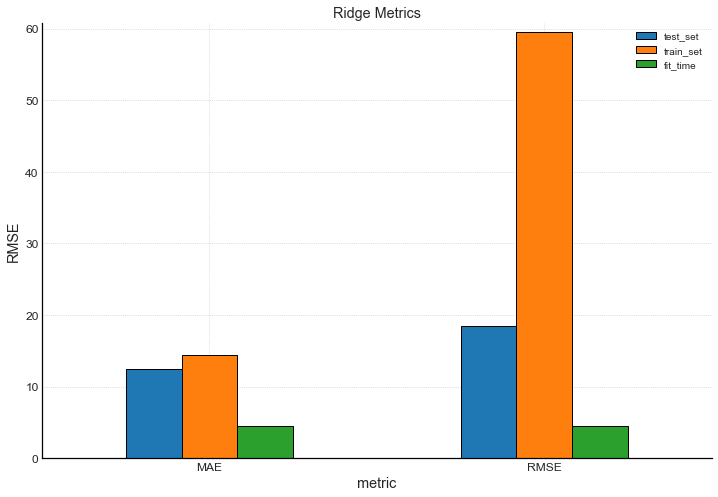

In [141]:
plot_model_metrics(ridge_metrics_df, 'Ridge Metrics')

In [41]:
# PLOT COEFFICIENTS

# display coefficients
feature_mask = ridge_model.named_steps['feature select'].get_support()
X_train.columns.values[feature_mask]
ridge_coef_df = pd.DataFrame({
    'coef_names': X_train.columns.values[feature_mask],
    'coef_values': ridge_model.steps[-1][-1].coef_[0],
    'model_name': 'ridge'
}).sort_values(by='coef_values', ascending=False)

ridge_coef_df

,coef_names,coef_values,model_name
1,cost_per_watt,18240.019961,ridge
3,area_est,21.538108,ridge
2,annual_insolation,9.439249,ridge
4,power_density,9.439249,ridge
5,year_freq,-6.983782,ridge
0,size_kw,-7.651716,ridge


In [42]:
# plot_coefficients(ridge_coef_df)

In [43]:
# sns.scatterplot(x=y_train_pred.ravel(), y=y_train.cost.values)
# plt.show()

# ElasticNet

Fit time: 5.297987222671509


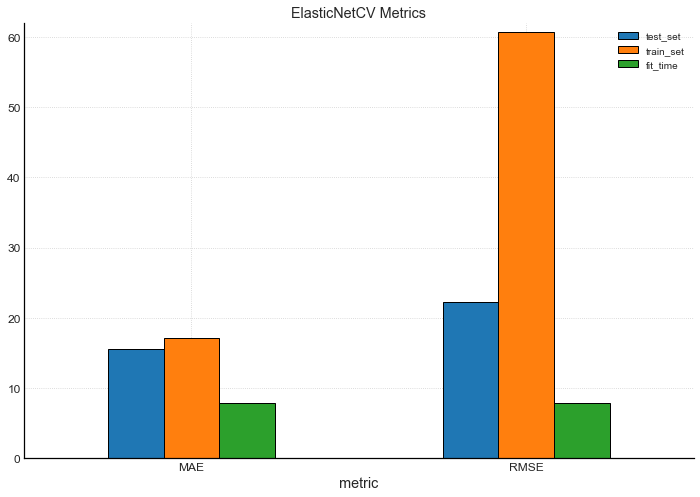

In [44]:
# categorical_df = pd.concat([pv_dm[['state']], df_2.drop('month_install_cnt', axis=1)], axis=1)
# drop_this = ['month_install_cnt', 'annual_pv_prod', 'tilt1', 'state_freq', 'tech_1_freq', 'tracking_type_freq']

# X_train, y_train, X_test, y_test = train_test_split(df_2.drop(drop_this, axis=1), 
#                                                     '2015-05-31', '2015-06-01')

# # fit model
# # predict on train and test
# # display metrics
# elasticnet_cv_model = build_pipeline(
#     linear_model.ElasticNetCV,
#     l1_ratio=0.95,
#     alphas=np.logspace(-2, 0, 100),
#     cv=5,
#     n_jobs=6,
#     k_select='all',
#     random_state=11,   
# )
# fit_start = time.time()
# elasticnet_cv_model.fit(X_train, y_train)
# print('Fit time:', time.time() - fit_start)
# y_pred = elasticnet_cv_model.predict(X_test)
# y_train_pred = elasticnet_cv_model.predict(X_train)

# # display metrics
# model_metrics(y_train, y_test, y_pred, y_train_pred)

# display coefficients
# coefficients(elasticnet_cv_model)

enet_metrics_df, elasticnet_cv_model = build_model(
    linear_model.ElasticNetCV,
    l1_ratio=0.95,
    alphas=np.logspace(-2, 0, 100),
    cv=5,
    n_jobs=6,
    k_select='all',
    random_state=11,  
    model_name='elastic-net-cv'
           
)
enet_metrics_df
plot_model_metrics(enet_metrics_df, 'ElasticNetCV Metrics')

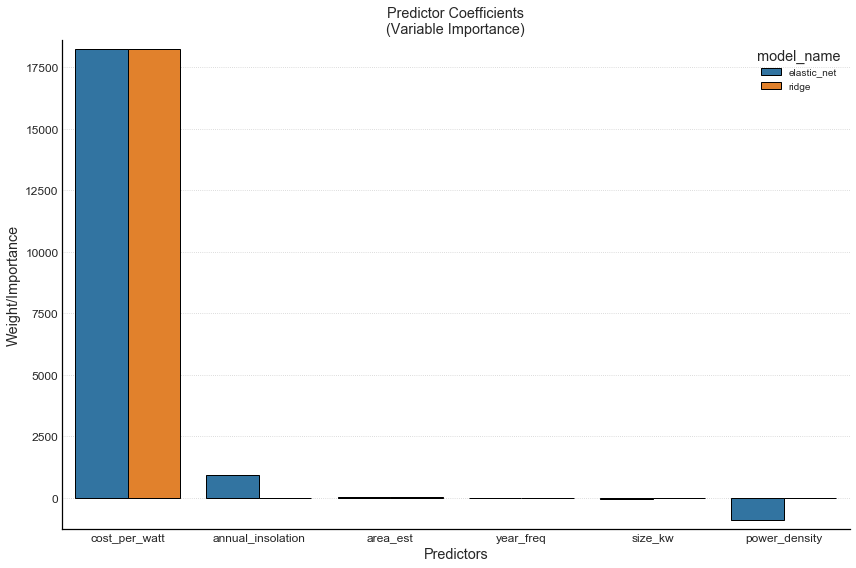

In [45]:
feature_mask = elasticnet_cv_model.named_steps['feature select'].get_support()
X_train.columns.values[feature_mask]
enet_cv_df = pd.DataFrame({
    'coef_names': X_train.columns.values[feature_mask],
    'coef_values': elasticnet_cv_model.steps[-1][-1].coef_,
    'model_name': 'elastic_net'
}).sort_values(by='coef_values', ascending=False)

coefficients(elasticnet_cv_model)

# plot_coefficients(enet_cv_df)
# print(pd.concat([enet_cv_df, ridge_coef_df]))

sns.barplot(x='coef_names',
            y='coef_values',
            hue='model_name',
            data=pd.concat([enet_cv_df, ridge_coef_df]),
            edgecolor='k'
           )
plt.xlabel('Predictors')
plt.ylabel('Weight/Importance')
plt.title('Predictor Coefficients\n(Variable Importance)')
plt.tight_layout()
plt.show()

In [139]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612072 entries, 1998-04-08 to 2017-12-28
Data columns (total 13 columns):
size_kw               612072 non-null float64
cost_per_watt         612068 non-null float64
annual_pv_prod        612072 non-null float64
annual_insolation     612067 non-null float64
tilt1                 307962 non-null float64
area_est              612067 non-null float64
power_density         612067 non-null float64
month_install_cnt     612072 non-null float64
state_freq            612072 non-null float64
tech_1_freq           358820 non-null float64
tracking_type_freq    328959 non-null float64
year_freq             612072 non-null float64
cost                  612072 non-null float64
dtypes: float64(13)
memory usage: 85.4 MB


Fit time: 2.8890395164489746


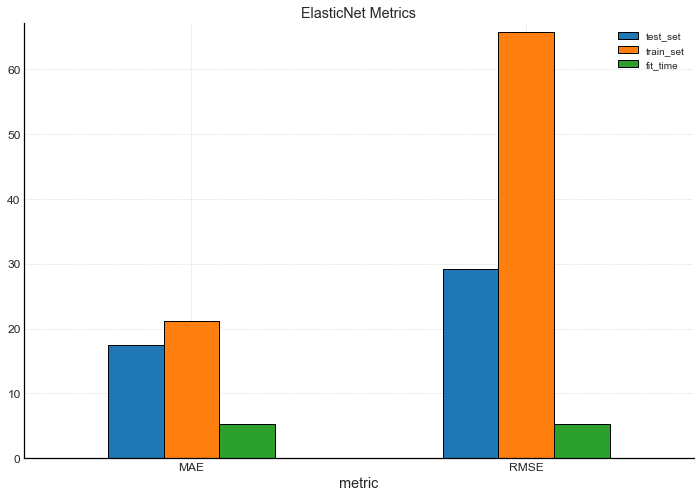

In [46]:
# elastic net
enet_metrics_df, elasticnet_model = build_model(
    linear_model.ElasticNet,
    l1_ratio=0.9999,
    alpha=0.005,
    k_select=6,
    random_state=11,  
    model_name='elastic-net-cv'
           
)
enet_metrics_df

# display coefficients
coefficients(elasticnet_model)

plot_model_metrics(enet_metrics_df, 'ElasticNet Metrics')

# Cross Validate Model

In [88]:

def validate_pipeline(model, data=df_2, n_splits=5):
    
    X_train, y_train, X_test, y_test = train_test_split(data, '2015-05-31', '2015-06-01')
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    X = X_train.reset_index()
    y = y_train.reset_index()

    test_score_ls = []
    train_score_ls = []
    train_data_ls = []
    fit_time_ls = []

    for train_index, test_index in tscv.split(X):
        # Split data using indices
        X_train_cv, X_test_cv = X.loc[train_index, :].drop(['index'], axis=1), X.loc[test_index, :].drop(['index'], axis=1)
        y_train_cv, y_test_cv = y.loc[train_index, :].drop(['index'], axis=1), y.loc[test_index, :].drop(['index'], axis=1)

        # append the amount of training data
        train_data_ls.append(y_train_cv.shape[0])

        # fit model and measure fit time
        fit_start = time.time()
        model.fit(X_train_cv, y_train_cv)
        fit_time_ls.append(time.time() - fit_start)

        # make predictions on train and test splits
        y_pred_cv = model.predict(X_test_cv)
        y_train_pred_cv = model.predict(X_train_cv)

        # append scores
        train_score_ls.append(np.sqrt(mean_squared_error(y_train_cv, y_train_pred_cv)))
        test_score_ls.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))

    # model stats
    model_stats_df = pd.DataFrame({
        'training_data': train_data_ls,
        'cv_test_rmse': test_score_ls, 
        'cv_train_rmse': train_score_ls,
        'cv_fit_time': fit_time_ls,
    })
    return model_stats_df

def plot_learning_curve(data, title=''):
    sns.lineplot(y=data['cv_test_rmse'],
                 x=data['training_data'],
                )
    sns.lineplot(y=data['cv_train_rmse'],
                 x=data['training_data'],
                )
    plt.ylabel('RMSE')
    plt.xlabel('Training Data')
    plt.axhline(y=data['cv_test_rmse'].min(), linestyle='--', color='red')
    plt.legend((
        f"Validation RMSE Min: {np.round(data['cv_test_rmse'].min(), 4)}",
        f"Training RMSE Min: {np.round(data['cv_train_rmse'].min(), 4)}",
    ))
    plt.title("Learning Curve\n"+title)
    plt.tight_layout()
    plt.show()

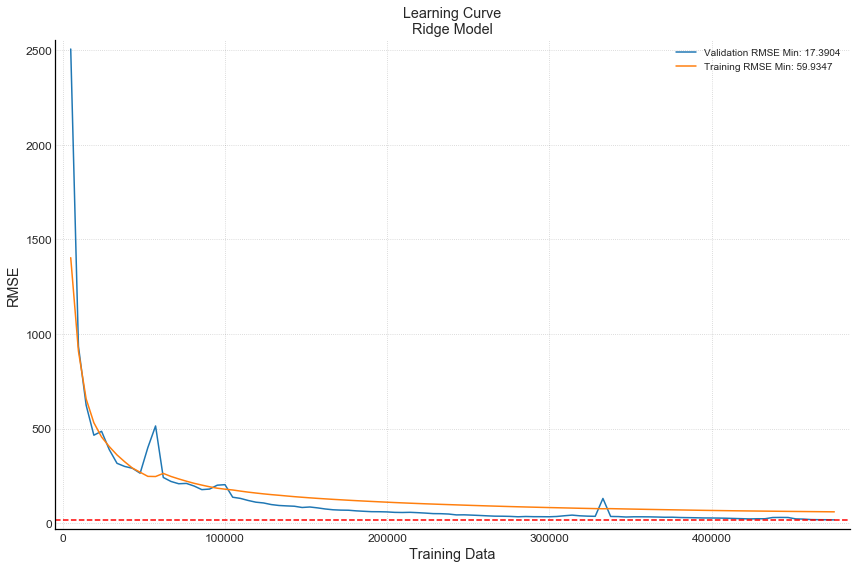

In [89]:
# validate model and plot learning curve
validation_data = validate_pipeline(ridge_model, n_splits=100)
plot_learning_curve(validation_data, 'Ridge Model')

In [138]:
validation_data[['cv_test_rmse', 'cv_train_rmse', 'cv_fit_time']].agg(['median', 'mean'])

,cv_test_rmse,cv_train_rmse,cv_fit_time
median,49.206233,97.404554,0.245223
mean,132.511957,154.728577,0.286250


# Plot Alpha vs MSE

In [110]:
# ridge_model.set_params()['regressor'].alpha = 10
# ridge_model.get_params()['regressor__alpha']

10

In [137]:

def plot_alpha_mse(model, alphas):
    """
    Plot relationship between hyperparameter `alpha` and RMSE.
    
    """
    train_rmse_ls = []
    test_rmse_ls = []
    
    for alpha in alphas:
#         ridge_model = build_pipeline(
#             linear_model.Ridge,
#             alpha=alpha,
#             k_select=6,
#             random_state=11,   
#         )
        model.set_params()['regressor'].alpha = alpha
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        # metrics
        train_rmse_ls.append(metrics(y_train, y_train_pred)[2])
        test_rmse_ls.append(metrics(y_test, y_pred)[1])
        
    plt.subplots(1,2)
    plt.subplot(211)
    sns.lineplot(x=alphas,y=train_rmse_ls)
    plt.title('Train RMSE vs Alpha')
    plt.ylabel('RMSE')
#     plt.show()
    
    plt.subplot(212)
    sns.lineplot(x=alphas,y=test_rmse_ls)
    plt.title('Test RMSE vs Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
#     plt.legend(('Train RMSE', 'Test RMSE'))
    
#     plt.tight_layout()
    plt.show()
    return pd.DataFrame({
        'train_rmse': train_rmse_ls,
        'test_rmse': test_rmse_ls
    })

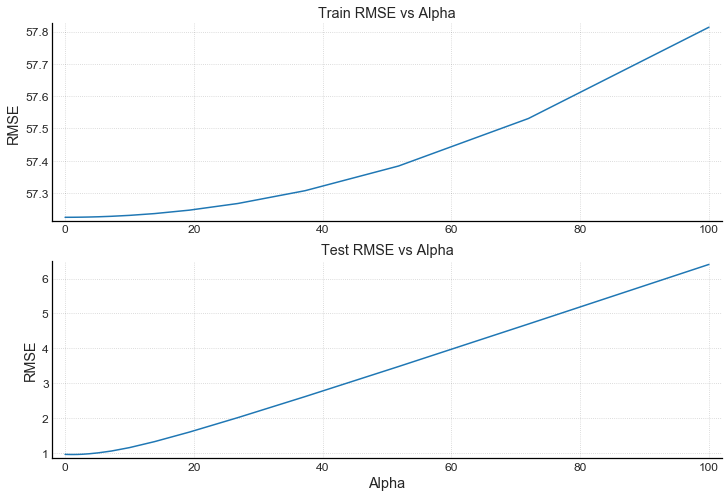

In [143]:
np.logspace(-5, 0.5, 10)
results = plot_alpha_mse(ridge_model, np.logspace(-5, 2, 50))

In [142]:
# results

## Kernel Ridge

In [43]:
# KERNEL RIDGE
# NOTE: 
# - Results in Memory Error


# num_df = get_numeric_data(pv_dm).sample
# X_train, y_train, X_test, y_test = train_test_split(num_df, '2015-05-31', '2015-06-01')

# krr = build_pipeline(KernelRidge, alpha=0.021, kernel='rbf', degree=3, gamma=0.3, k_select=5)

# fit_start = time.time()
# y_pred = krr.fit(X_train, y_train.values.ravel()).predict(X_test)
# print('Fit-predict time:', time.time() - fit_start)
# model_metrics(krr, X_train, y_train, X_test, y_test, y_pred)


## Grid Search Pipeline Parameters

In [61]:
# model.named_steps['regressor'].alpha
# np.linspace(10, 15, 10)
# np.logspace(2.35,2.45, 5)
# np.logspace(0.85, 1.3, 5)
# np.linspace(8,9,5)

array([ 7.07945784,  9.17275935, 11.88502227, 15.39926526, 19.95262315])

In [47]:
# GRIDSEARCH
ridge_model.get_params()['preprocessor__pipeline-1__scaler__quantile_range'] 
# ridge_model.set_params()['preprocessor'].transformers[0][1]['scaler'].quantile_range = (30,70)

(25.0, 75.0)

In [48]:
search_params = {}
# search_params['regressor__alpha'] = np.logspace(0.85, 1.3, 5)
# search_params['poly features__degree'] = [3,4]
search_params['feature select__k'] = [5,6]
search_params['preprocessor__pipeline-1__scaler'] = [RobustScaler(), MinMaxScaler(), MaxAbsScaler(), StandardScaler()]
# search_params['preprocessor__pipeline-1__scaler__quantile_range'] = [(25,75), (20,80), (30,70), (35,65)]

grid_search = GridSearchCV(
    ridge_model,
    search_params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
               

In [49]:
print('Best score (RMSE):',(-1*grid_search.best_score_)**(1/2))
print(grid_search.best_params_)
# grid_search.cv_results_['mean_fit_time']

Best score (RMSE): 56.693846498929744
{'feature select__k': 5, 'preprocessor__pipeline-1__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


## Using Best Params

In [50]:
# measure fit time
model = grid_search.best_estimator_

fit_start = time.time()
model.fit(X_train, y_train)
print('Fit time:', time.time() - fit_start)
# make predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# display metrics
metrics_df = pd.DataFrame({
    'metric': ['r2_score', 'MAE', 'RMSE'],
    'test_set': metrics(y_test, y_pred),
    'train_set': metrics(y_train, y_train_pred),
#     'regressor': str(model_name),
    'fit_time': time.time() - fit_start
})
metrics_df

Fit time: 0.35024499893188477


,metric,test_set,train_set,fit_time
0,r2_score,0.999999,0.999981,0.668993
1,MAE,7.468807,8.754028,0.668993
2,RMSE,12.571842,57.798470,0.668993


## RandomForestRegressor

Fit time: 5.386889219284058


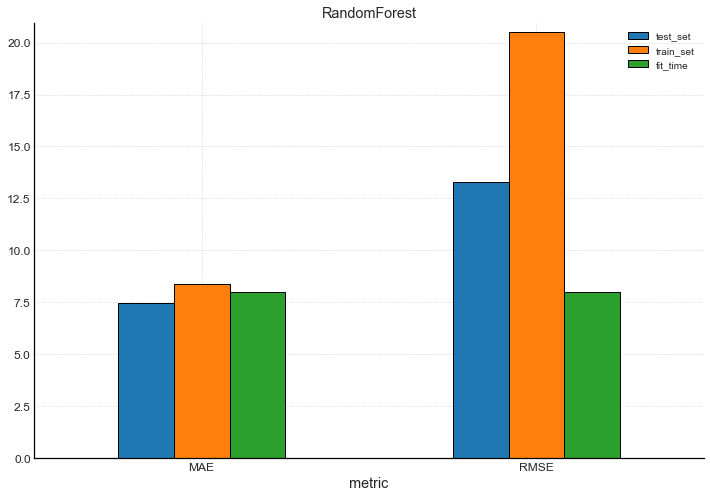

In [130]:
# numerica data
X_train, y_train, X_test, y_test = train_test_split(df_2.drop(drop_this, axis=1), 
                                                    '2015-05-31', '2015-06-01')

rf_params = {    
    'max_depth': 10,
    'n_estimators': 15,
#     'min_samples_split': 3,
    'n_jobs': -1,   
}
# define regressor and build pipeline
rf_model_stats, rf_model = build_model(
    RandomForestRegressor,
    **rf_params,
    model_name='rf'
)
plot_model_metrics(rf_model_stats, 'RandomForest')

In [131]:
rf_model_stats

,metric,test_set,train_set,regressor,fit_time
0,r2_score,0.999999,0.999998,rf,7.983247
1,MAE,7.448307,8.390257,rf,7.983247
2,RMSE,13.275869,20.510851,rf,7.983247


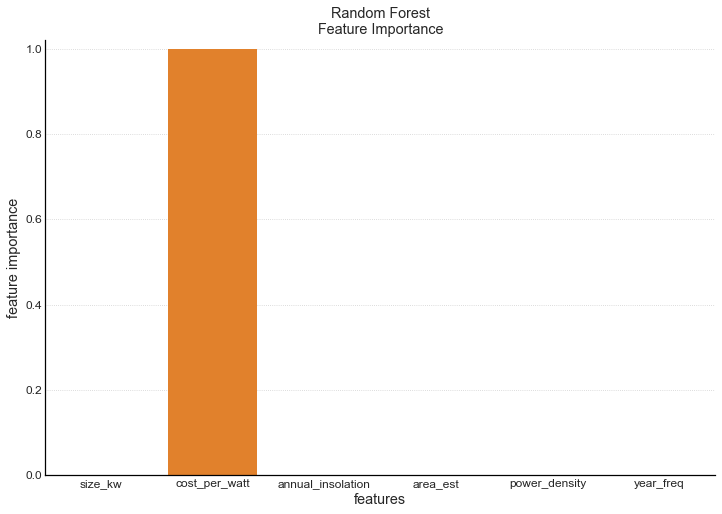

In [123]:
rf_features_df = pd.DataFrame({
    'features': X_train.columns.values[rf_model.named_steps['feature select'].get_support()],
    'feature importance': rf_model.named_steps['regressor'].feature_importances_,  
    
})
rf_features_df
# plot feature importance
sns.barplot(x=rf_metrics_df['features'],
           y=rf_metrics_df['feature importance'],
           )
plt.title('Random Forest\nFeature Importance')
plt.show()

## Grid Search: RandomForest

In [97]:
np.arange(30,35)

array([30, 31, 32, 33, 34])

In [124]:
rf_grid_params = {}
rf_grid_params['regressor__max_depth'] = [16,20,24]
rf_grid_params['regressor__n_estimators'] = [20,30,40]
# rf_grid_params['regressor__min_samples_split'] = [3,4,5]
# rf_grid_params['feature select__k'] = [7]

In [125]:


grid_search = GridSearchCV(
    rf_model,
    rf_grid_params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    n_jobs=6,
)

grid_search.fit(X_train, y_train.values.ravel())
grid_start_time = time.perf_counter()
print('Search time:', time.perf_counter() - grid_start_time)

Search time: 328.72819040000013


In [126]:
print('Best RMSE:', (-1*grid_search.best_score_)**(1/2))
grid_search.best_params_

Best RMSE: 46.18614389147458


{'regressor__max_depth': 16, 'regressor__n_estimators': 30}

## RF with Best Params

Fit time: 10.934925317764282
     metric  test_set  train_set regressor   fit_time
0  r2_score  0.999999   0.999999        rf  14.289971
1       MAE  1.633857   2.364324        rf  14.289971
2      RMSE  9.854489  12.023350        rf  14.289971


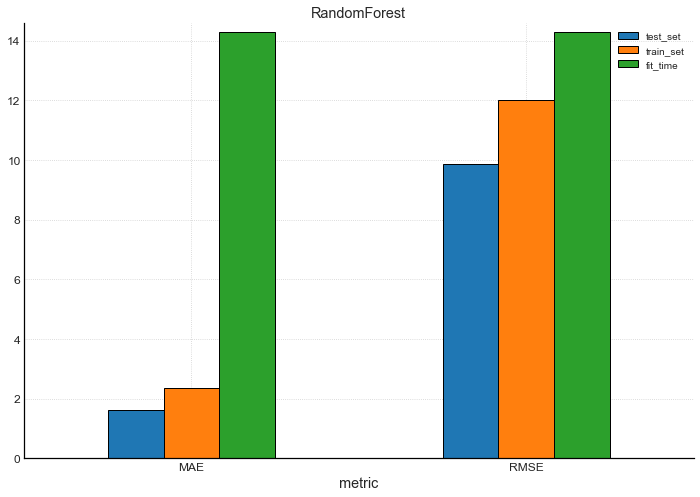

In [132]:
rf_params = {
    
    'max_depth': grid_search.best_params_['regressor__max_depth'],
    'n_estimators': grid_search.best_params_['regressor__n_estimators'],
#     'min_samples_split': grid_search.best_params_['regressor__min_samples_split'],
    'n_jobs': -1,
    
}
# define regressor and build pipeline
rf_model_stats, rf_model = build_model(
    RandomForestRegressor,
    **rf_params,
    model_name='rf'
)
print(rf_model_stats)
plot_model_metrics(rf_model_stats, 'RandomForest')

## GradientBoosting

In [148]:
gb_params = dict(
    n_estimators = 100,
#     subsample=0.8,
    loss='lad'
)

In [149]:
# X_train, y_train, X_test, y_test = train_test_split(df_2.drop(drop_this, axis=1), 
#                                                     '2015-05-31', '2015-06-01')

# define regressor and build pipeline
gb_model_stats, gb_model = build_model(
    GradientBoostingRegressor,
    **gb_params,
    model_name='gb'
)
gb_model_stats

Fit time: 39.80713438987732


,metric,test_set,train_set,regressor,fit_time
0,r2_score,0.999749,0.999753,gb,42.735793
1,MAE,145.106867,157.752625,gb,42.735793
2,RMSE,189.503694,206.513787,gb,42.735793


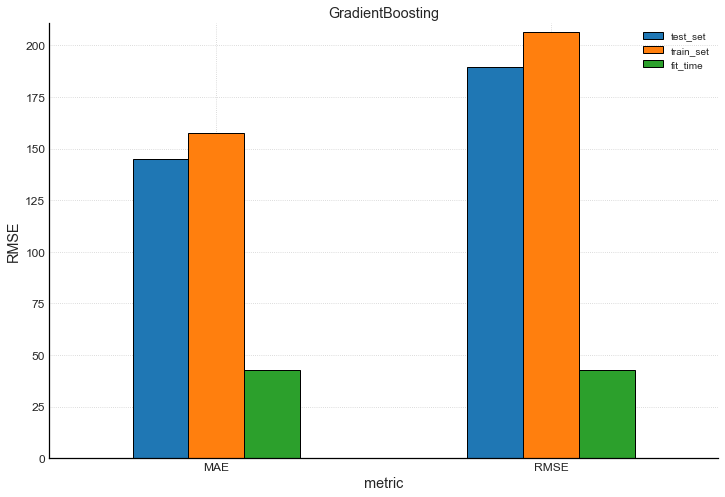

In [150]:
plot_model_metrics(gb_model_stats, 'GradientBoosting')

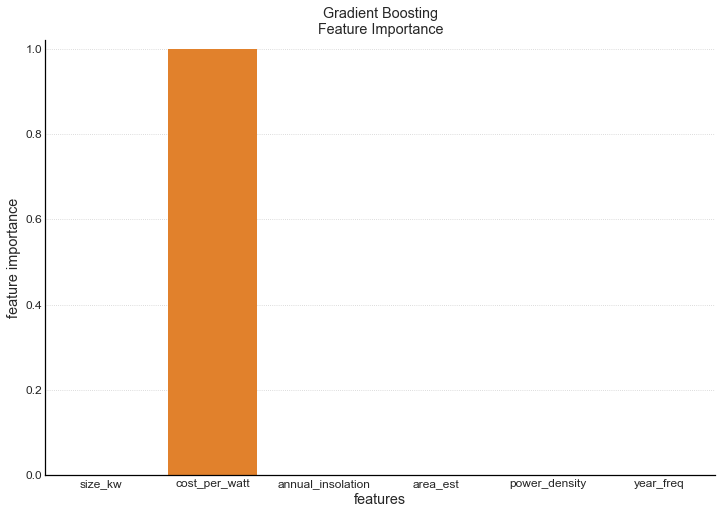

In [66]:
gb_metrics_df = pd.DataFrame({
    'features': X_train.columns.values[gb_model.named_steps['feature select'].get_support()],
    'feature importance': gb_model.named_steps['regressor'].feature_importances_,  
    
})
gb_metrics_df
# rf_metrics_df.plot(kind='bar')
# plt.xticks(ticks=np.arange(6), labels=rf_metrics_df['features'], rotation=0)
# plt.ylabel('')
# plt.show()

sns.barplot(x=gb_metrics_df['features'],
           y=gb_metrics_df['feature importance'],
           )
plt.title('Gradient Boosting\nFeature Importance')
plt.show()

# Grid Search GradientBoosting

In [158]:
np.arange(0.18,0.28, 0.02)

array([0.18, 0.2 , 0.22, 0.24, 0.26, 0.28])

In [68]:
gb_grid_params = {}
# gb_grid_params['regressor__learning_rate'] = [0.18]
gb_grid_params['regressor__n_estimators'] = [140,180,220]

In [69]:
# 
grid_start_time = time.perf_counter()
grid_search = GridSearchCV(
    gb_model,
    gb_grid_params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)
print('Search time:', time.perf_counter() - grid_start_time)

Search time: 309.69264399999975


In [72]:
print('Best RMSE:', (-1*grid_search.best_score_)**(1/2))
grid_search.best_params_['regressor__n_estimators']

Best RMSE: 104.43601783313737


220

# Best Params w/GB

In [73]:
# define regressor and build pipeline
gb_model_stats, gb_model = build_model(
    GradientBoostingRegressor,
    n_estimators=grid_search.best_params_['regressor__n_estimators'],
    model_name='gb'
)
gb_model_stats


Fit time: 76.7989068031311


,metric,test_set,train_set,regressor,fit_time
0,r2_score,0.999950,0.999942,gb,80.484076
1,MAE,65.625654,67.996938,gb,80.484076
2,RMSE,84.336385,100.405202,gb,80.484076


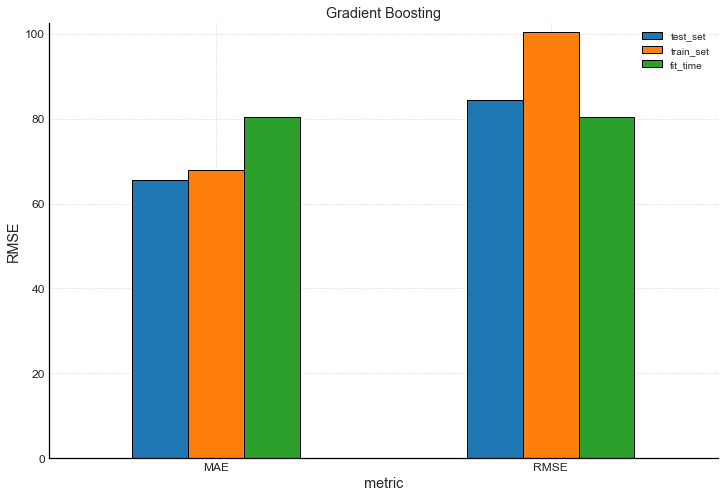

In [142]:
plot_model_metrics(gb_model_stats, 'Gradient Boosting')

In [144]:
GradientBoostingRegressor??

Init signature:
GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
)
Source:        
class GradientBoostingRegressor(BaseGradientBoosting, RegressorMixin):
    """Gradient Boosting for regression.

    GB builds an additive model in a forward stage-wise fashion;
    it allows for the optimization of arbitrary differentiable loss functions.
    In each stage a regression tree is fit on the negative gradient of the
    given loss function.

    Read more in the :ref:`User Guide <gradient_boosting>`.

    Parameters
    --

## GridSearch: Pipeline
Evaluate various regressor within the pipeline with their respective hyperparameters. 


In [86]:
pipe_stats, search_this_pipeline = build_model(
    linear_model.Ridge,
    alpha=2.14,
    model_name='pipeline')

Fit time: 0.3925957679748535


In [87]:
pipe_stats

,metric,test_set,train_set,regressor,fit_time
0,r2_score,1.000000,0.999981,pipeline,0.743031
1,MAE,0.962438,3.857742,pipeline,0.743031
2,RMSE,8.252927,57.225129,pipeline,0.743031


In [79]:
# regressor_params = {}

# regressor_params['regressor'] = [linear_model.Ridge()]
# regressor_params['regressor__alpha'] = np.logspace(0.01, 1, 50)

In [388]:
# np.arange(0.99, 1.00, 0.001)

In [389]:
regressor_params = [
    {
        'regressor': [linear_model.Ridge()],
        'regressor__alpha': np.logspace(-1, 1, 10),
#         'poly features__degree': [3,4]
    },
    {
        'regressor': [linear_model.ElasticNet()],
        'regressor__alpha': np.logspace(0.01, 1, 10),
        'regressor__l1_ratio': np.arange(0.99, 1.00, 0.001),
#         'poly features__degree': [3,4],
    },
#     {
#         'regressor': [RandomForestRegressor()],
#         'regressor__max_depth': [19,20,21],
#         'regressor__n_estimators': np.arange(32,38),
#     },
#     {
#         'regressor': [GradientBoostingRegressor()],
#         'regressor__n_estimators': [114,115],
#         'regressor__learning_rate': [0.18, 0.19],
#     },
#     {
#         'regressor': [AdaBoostRegressor()],
#         'regressor__n_estimators': [45,50,55],
#     }
]

In [390]:
# numerica data
X_train, y_train, X_test, y_test = train_test_split(df_2, '2015-05-31', '2015-06-01')

grid_start_time = time.perf_counter()
regressor_search = GridSearchCV(
    search_this_pipeline,
    regressor_params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=3,
    n_jobs=7,
    verbose=1,
    iid=False
)
regressor_search.fit(X_train, y_train)
print('Search time:', np.round((time.perf_counter() - grid_start_time) / 60, 4), 'minutes')

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   29.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  8.1min
[Parallel(n_jobs=7)]: Done 360 out of 360 | elapsed: 11.9min finished


Search time: 713.5909996999999


In [391]:
best_model = regressor_search.best_estimator_
print('Best regressor:    ', regressor_search.best_estimator_.get_params()['regressor'])
print('Best score (RMSE): ', np.sqrt(regressor_search.best_score_*-1))

Best regressor:     Ridge(alpha=2.1544346900318834, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Best score (RMSE):  54.277062512640136
